# Bert Model

In [2]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np
import json
import matplotlib.pyplot as plt

file_path = '/kaggle/input/nlp-a4-content/'
with open(file_path + 'train_file.json', 'r') as f:
    conversations = json.load(f)

with open(file_path + 'val_file.json', 'r') as f:
    val_conversations = json.load(f)

# demo 
file_test = '/kaggle/input/meld-train-efr/MELD_train_efr.json'

with open(file_test, 'r') as f:
    test_conversations = json.load(f)

class EmotionDataset(Dataset):
    def __init__(self, conversations, tokenizer):
        self.conversations = conversations
        self.tokenizer = tokenizer

    def __len__(self):
        return sum(len(convo['utterances']) for convo in self.conversations)

    def __getitem__(self, idx):
        utterances, emotions = [], []
        for convo in self.conversations:
            utterances.extend(convo['utterances'])
            emotions.extend(convo['emotions'])

        emotion_to_int = {'joy': 0, 'sadness': 1, 'anger': 2, 'disgust': 3, 'surprise': 4, 'fear': 5, 'neutral': 6}
        label = emotion_to_int[emotions[idx]]
        return utterances[idx], label

tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
dataset = EmotionDataset(conversations, tokenizer)
val_dataset = EmotionDataset(val_conversations, tokenizer)

test_dataset = EmotionDataset(test_conversations, tokenizer)

def custom_collate_fn(batch):
    texts, labels = zip(*batch)
    encoding = tokenizer(
        list(texts),
        return_tensors='pt',
        padding=True,
        truncation=True
    )
    return {
        'input_ids': encoding['input_ids'],
        'attention_mask': encoding['attention_mask'],
        'labels': torch.tensor(labels, dtype=torch.long)
    }

data_loader = DataLoader(dataset, batch_size=32, shuffle=True, collate_fn=custom_collate_fn)
val_data_loader = DataLoader(val_dataset, batch_size=32, collate_fn=custom_collate_fn)


#demo 
test_data_loader = DataLoader(test_dataset, batch_size=32, collate_fn=custom_collate_fn)

model = BertForSequenceClassification.from_pretrained(
    'bert-base-cased',
    num_labels=7
)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 

The secret `HF_TOKEN` does not exist in your Colab secrets.

To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.

You will be able to reuse this secret in all of your notebooks.

Please note that authentication is recommended but still optional to access public models or datasets.

  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']

You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:429: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning

  warnings.warn(

100%|██████████| 1843/1843 [09:01<00:00,  3.40it/s]

100%|██████████| 1843/1843 [09:29<00:00,  3.24it/s]

100%|██████████| 1843/1843 [09:17<00:00,  3.31it/s]

100%|██████████| 1843/1843 [08:51<00:00,  3.47it/s]

100%|██████████| 1843/1843 [08:58<00:00,  3.42it/s]


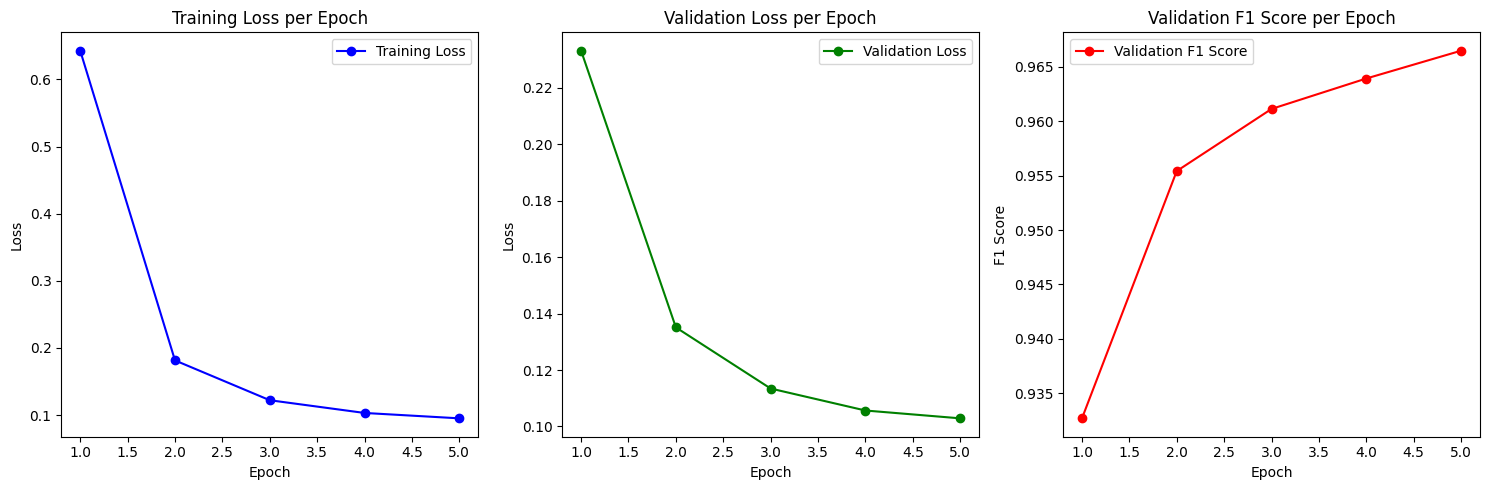

In [4]:
optimizer = AdamW(model.parameters(), lr=2e-5)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

epochs = 5
train_losses = []
val_losses = [] 
val_f1_scores = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for batch in tqdm(data_loader):
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0  
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for batch in val_data_loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            val_loss = outputs.loss 
            total_val_loss += val_loss.item() 

            predictions = torch.argmax(logits, dim=-1)
            all_predictions.append(predictions.cpu().numpy())
            all_true_labels.append(batch['labels'].cpu().numpy())

    avg_val_loss = total_val_loss / len(val_data_loader)  
    val_losses.append(avg_val_loss) 

    flat_predictions = np.concatenate(all_predictions, axis=0)
    flat_true_labels = np.concatenate(all_true_labels, axis=0)
    f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')
    val_f1_scores.append(f1)

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs + 1), train_losses, 'b-o', label='Training Loss')
plt.title('Training Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, epochs + 1), val_losses, 'g-o', label='Validation Loss') 
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, epochs + 1), val_f1_scores, 'r-o', label='Validation F1 Score')
plt.title('Validation F1 Score per Epoch')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.legend()

plt.tight_layout()
plt.show()

In [9]:
print(val_f1_scores[4])

0.9662376285939


# DEMO

In [4]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import json
device = 'cpu'
model.load_state_dict(torch.load("/kaggle/input/checkpoints-a4-temp/bert-base-erc-epoch-4.pt", map_location=torch.device('cpu')))
model.eval()

all_true_labels = []
all_predictions = []  
total_val_loss = 0
val_f1_scores = []  

for batch in test_data_loader:
    with torch.no_grad():
        try:
            batch = {k: v.to(device) for k, v in batch.items()}
            outputs = model(**batch)
            logits = outputs.logits
            val_loss = outputs.loss 
            total_val_loss += val_loss.item()  

            predictions = torch.argmax(logits, dim=-1)
            all_predictions.append(predictions.cpu().numpy())  
            all_true_labels.append(batch['labels'].cpu().numpy()) 
        except Exception as e:
            print("Verify input data:", e)


flat_predictions = np.concatenate(all_predictions, axis=0)  
flat_true_labels = np.concatenate(all_true_labels, axis=0)  
f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')  
val_f1_scores.append(f1)  
print("F1 Score:", f1)

F1 Score: 0.9661214682237175


# LSTM

In [12]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import f1_score
from tqdm import tqdm
import numpy as np
import json
from torch.nn.utils.rnn import pad_sequence
from collections import defaultdict

file_path = "/kaggle/input/nlp-a4-content/"
with open(file_path + 'train_file.json', 'r') as f:
    conversations = json.load(f)

with open(file_path + 'val_file.json', 'r') as f:
    val_conversations = json.load(f)
# demo 
file_test = '/kaggle/input/meld-train-efr/MELD_train_efr.json'

with open(file_test, 'r') as f:
    test_conversations = json.load(f)
def tokenizer(text):
    return text.split()

def build_vocab(conversations):
    vocab = defaultdict(lambda: len(vocab))
    vocab['<pad>'] = 0
    for convo in conversations:
        for sentence in convo['utterances']:
            tokens = tokenizer(sentence)
            [vocab[token] for token in tokens]
    return dict(vocab)

vocab = build_vocab(conversations)

class EmotionDataset(Dataset):
    def __init__(self, conversations, vocab):
        self.conversations = conversations
        self.vocab = vocab

    def __len__(self):
        return sum(len(convo['utterances']) for convo in self.conversations)

    def __getitem__(self, idx):
        utterances, emotions = [], []
        for convo in self.conversations:
            utterances.extend(convo['utterances'])
            emotions.extend(convo['emotions'])

        emotion_to_int = {'joy': 0, 'sadness': 1, 'anger': 2, 'disgust': 3, 'surprise': 4, 'fear': 5, 'neutral': 6}
        label = emotion_to_int[emotions[idx]]
        tokens = tokenizer(utterances[idx])
        indices = [self.vocab.get(token, self.vocab['<pad>']) for token in tokens]
        return torch.tensor(indices, dtype=torch.long), torch.tensor(label, dtype=torch.long)

In [13]:
def collate_batch(batch):
    labels = torch.tensor([item[1] for item in batch])
    sequences = [item[0] for item in batch]
    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)
    return padded_sequences, labels

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, num_layers=1):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(0.5)

    def forward(self, text):
        embedded = self.embedding(text)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        output = self.fc(lstm_out[:, -1, :])
        return output

vocab_size = len(vocab)
embedding_dim = 100
hidden_dim = 256
output_dim = 7
model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
data_loader = DataLoader(EmotionDataset(conversations, vocab), batch_size=32, shuffle=True, collate_fn=collate_batch)
val_data_loader = DataLoader(EmotionDataset(val_conversations, vocab), batch_size=32, collate_fn=collate_batch)

#Demo
test_data_loader = DataLoader(EmotionDataset(test_conversations, vocab), batch_size=32, collate_fn=collate_batch)


In [ ]:

epochs = 5
train_losses = []
val_losses = []
val_f1_scores = []

for epoch in range(epochs):
    model.train()
    total_loss = 0
    for texts, labels in tqdm(data_loader):
        texts = texts.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        output = model(texts)
        loss = nn.CrossEntropyLoss()(output, labels)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_train_loss = total_loss / len(data_loader)
    train_losses.append(avg_train_loss)

    model.eval()
    total_val_loss = 0
    all_predictions = []
    all_true_labels = []
    with torch.no_grad():
        for texts, labels in val_data_loader:
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            val_loss = nn.CrossEntropyLoss()(output, labels)
            total_val_loss += val_loss.item()
            predictions = torch.argmax(output, dim=-1)
            all_predictions.append(predictions.cpu().numpy())
            all_true_labels.append(labels.cpu().numpy())

    avg_val_loss = total_val_loss / len(val_data_loader)
    val_losses.append(avg_val_loss)
    flat_predictions = np.concatenate(all_predictions, axis=0)
    flat_true_labels = np.concatenate(all_true_labels, axis=0)
    f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')
    val_f1_scores.append(f1)

In [8]:
print(val_f1_scores[4])

0.9587279882054506


100%|██████████| 1843/1843 [03:20<00:00,  9.21it/s]

100%|██████████| 1843/1843 [03:10<00:00,  9.66it/s]

100%|██████████| 1843/1843 [03:17<00:00,  9.35it/s]

100%|██████████| 1843/1843 [03:12<00:00,  9.59it/s]

100%|██████████| 1843/1843 [03:03<00:00, 10.02it/s]


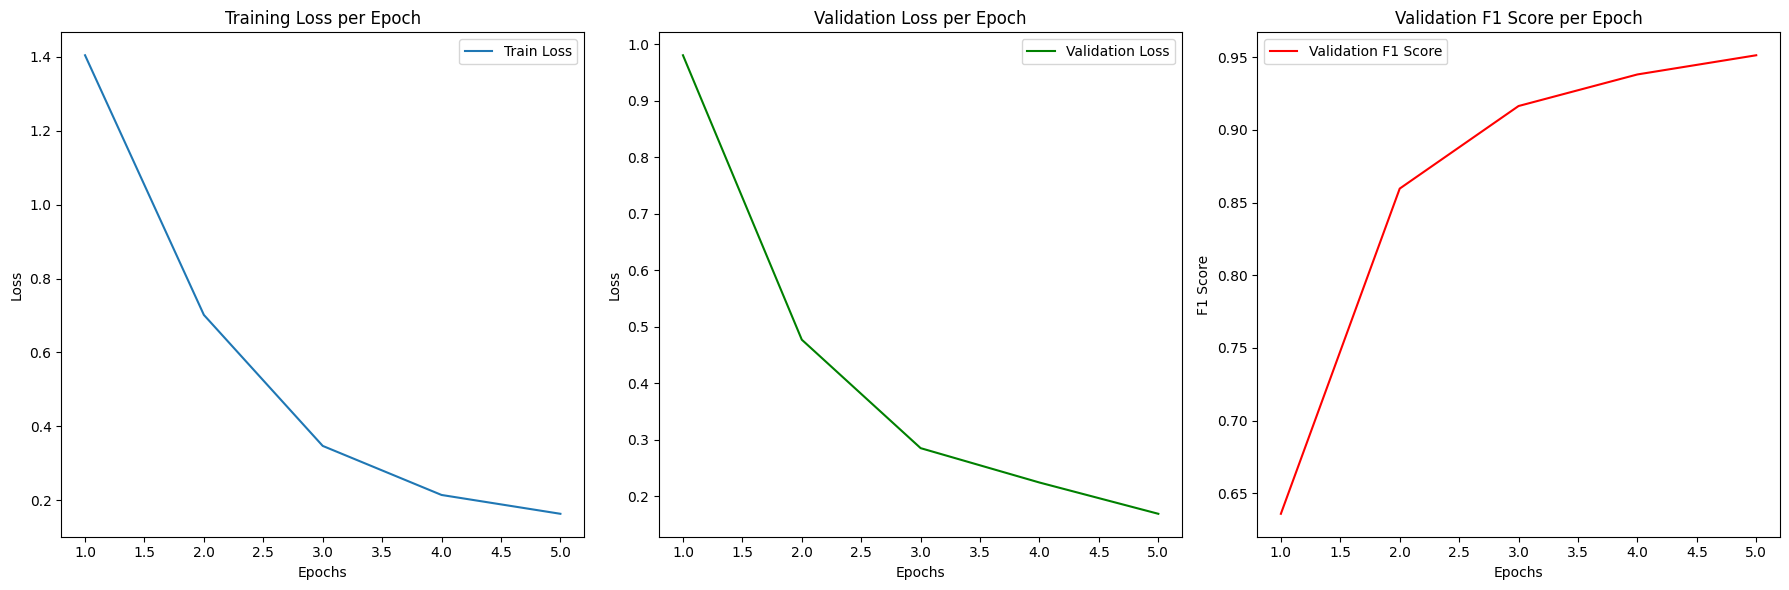

In [3]:
plt.figure(figsize=(18, 6))
plt.subplot(1, 3, 1)
plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(1, epochs+1), val_losses, label='Validation Loss', color='g')  #
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Loss per Epoch')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(1, epochs+1), val_f1_scores, label='Validation F1 Score', color='r')
plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('Validation F1 Score per Epoch')
plt.legend()

plt.tight_layout()
plt.show()


# Demo

In [17]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification, BertConfig
import json
device = "cpu"
model.load_state_dict(torch.load("/kaggle/input/checkpoints-a4-temp/lstm-erc-epoch-4.pt", map_location=torch.device('cpu')))
model.eval()

all_true_labels = []
all_predictions = []  
total_val_loss = 0
val_f1_scores = []  

for texts, labels in test_data_loader:
    with torch.no_grad():
        try:
            texts = texts.to(device)
            labels = labels.to(device)

            output = model(texts)
            val_loss = nn.CrossEntropyLoss()(output, labels)
            total_val_loss += val_loss.item()
            predictions = torch.argmax(output, dim=-1)
            all_predictions.append(predictions.cpu().numpy())
            all_true_labels.append(labels.cpu().numpy()) 
        except Exception as e:
            print("Verify input data:", e)

flat_predictions = np.concatenate(all_predictions, axis=0)  
flat_true_labels = np.concatenate(all_true_labels, axis=0)  
f1 = f1_score(flat_true_labels, flat_predictions, average='weighted')  
val_f1_scores.append(f1)  
print("F1 Score:", f1)

F1 Score: 0.9376786999364225
